## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
print("The no. of rows in the dataset is {}".format(df.shape[0]))

The no. of rows in the dataset is 294478


c. The number of unique users in the dataset.

In [4]:
print("The no. of unique users in the dataset is {}".format(df.user_id.nunique()))

The no. of unique users in the dataset is 290584


d. The proportion of users converted.

In [5]:
print("The proportion of users converted is {}".format(len(df.query('converted==1'))/len(df.index)))

The proportion of users converted is 0.11965919355605512


e. The number of times the `new_page` and `treatment` don't match.

In [6]:
cat1 = len(df.query('group!="treatment" and landing_page=="new_page"'))
cat2 = len(df.query('group!="control" and landing_page=="old_page"'))
group = cat1+cat2
group

3893

f. Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


> *No rows with missing values*

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
#Create new dataframe from the original dataframe to ensure the rows that doesn't match as per finding in Question 1 above is removed.
df2 = df[((df['group']=='treatment')&(df['landing_page']=='new_page')) | ((df['group']=='control')&(df['landing_page']=='old_page'))]

In [9]:
# Double Check to ensure all of the correct rows were removed. As the rows removed were the ones that were not matched, hence searching for 'False' matching in df2 should result in 0.
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
print("There are {} of unique user ids in df2".format(df2['user_id'].nunique()))

There are 290584 of unique user ids in df2


b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
print("The duplicated user id in df2 is {}".format(df2[df2['user_id'].duplicated()]['user_id']))

The duplicated user id in df2 is 2893    773192
Name: user_id, dtype: int64


c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
#No. of rows before removing duplicate user_id
df2.shape

(290585, 5)

In [14]:
#Drop rows belonging to repeated user_id
df2 = df2.drop_duplicates(subset='user_id');

In [15]:
#No. of rows after duplicate user_id removed
df2.shape

(290584, 5)

In [16]:
#Double check to ensure no duplicated user_id remained in df2
sum(df2.duplicated())

0

>*As the question points out to remove **one** of the rows, the no. of rows have indeed been reduced by 1 row compared to previous version, and after double checking, there are no more duplicated values in df2 for the user_id*

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
print("The probability of an individual converting regardless of the page they receive is {}".format(df2['converted'].mean()))

The probability of an individual converting regardless of the page they receive is 0.11959708724499628


b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
print("The probability that an individual converting given that the individual was in the control group is {}".format(df2.query('group=="control"').converted.mean()))

The probability that an individual converting given that the individual was in the control group is 0.1203863045004612


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
print("The probability that an individual converting given that the individual was in the treatment group is {}".format(df2.query('group=="treatment"').converted.mean()))

The probability that an individual converting given that the individual was in the treatment group is 0.11880806551510564


d. What is the probability that an individual received the new page?

In [20]:
print("The probability that an individual received the new page is {}".format(len(df2[df2['landing_page']=='new_page'])/len(df2)))

The probability that an individual received the new page is 0.5000619442226688


e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Your answer goes here.**

**Answer**
> *Based on the results above of control group conversion rate of 0.1204 and treatment group conversion rate of 0.1188, these does not sufficiently indicated if the new page or old page would lead to more conversions. Also, as both of these rates are similar to each other, with only slight differences, other factors should need to be considered, more test hypothesis to be defined, as well as the p-value for the new and old page to be calculated. Only then, we may be able to conclude if the new treatment page would lead to more conversions.*

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**

**Answer** - $H_{1}$: $p_{new}$ > $p_{old}$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [21]:
p_new = df2.converted.mean()
print("The conversion rate for p_new under the null is {}".format(p_new))

The conversion rate for p_new under the null is 0.11959708724499628


b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [22]:
p_old = df2.converted.mean()
print("The conversion rate for p_old under the null is {}".format(p_old))

The conversion rate for p_old under the null is 0.11959708724499628


c. What is $n_{new}$, the number of individuals in the treatment group?

In [23]:
newpage_df = df2.query('landing_page=="new_page"')
n_new = newpage_df.shape[0]
print("The n_new the number of individuals in treatment group is {}".format(n_new))

The n_new the number of individuals in treatment group is 145310


d. What is $n_{old}$, the number of individuals in the control group?

In [24]:
oldpage_df = df2.query('landing_page=="old_page"')
n_old = oldpage_df.shape[0]
print("The n_old the number of individuals in control group is {}".format(n_old))

The n_old the number of individuals in control group is 145274


e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
new_page_converted = np.random.choice([0, 1], n_new, p = [p_new, 1-p_new])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted = np.random.choice([0, 1], n_old, p = [p_old, 1-p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
p_diff = new_page_converted.mean() - old_page_converted.mean()
p_diff

0.00071805858772389097

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [28]:
p_diffs = []

for i in range(10000):
    new_converted_simulation = np.random.binomial(n_new,p_new)/n_new
    old_converted_simulation = np.random.binomial(n_old,p_old)/n_old
    diff = new_converted_simulation - old_converted_simulation 
    p_diffs.append(diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

Text(0.5,1,'Null Hypothesis Conversion Rates Differences')

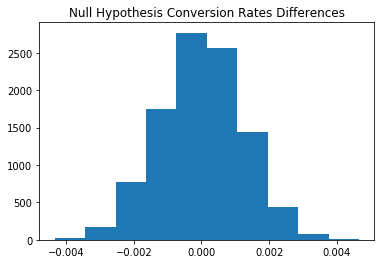

In [29]:
plt.hist(p_diffs);
plt.title("Null Hypothesis Conversion Rates Differences")

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [30]:
#Actual difference observed in ab_data
old_mean = df.query('landing_page == "old_page"')['converted'].mean()
new_mean = df.query('landing_page == "new_page"')['converted'].mean()
diff = new_mean - old_mean
diff


-0.0016367945992569882

In [31]:
#Prportion of the p_diffs greater than actual difference observed
print("The proportion of the p_diffs greater than actual difference observed is {}".format((p_diffs > diff).mean()))

The proportion of the p_diffs greater than actual difference observed is 0.9046


k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Put your answer here.**

**Answer**
> *The value calculated is the p-value, for which, this indicates that, there are no material difference between the conversion rate for control and treatment groups. This means that there is no significant advantage in converting to the new web page, and in fact, eventhough the old and new page is having similar numbers, the old web page seems to be better as the numbers depicted above. Also, to accept a null hypothesis, the p-value should be higher than the suggested p-value, and as per above, it's around 90% for which we would fail to reject the Null hypothesis and thus, maintains the old page.*

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [32]:
import statsmodels.api as sm

convert_old = sum(df2.query('landing_page == "old_page"')['converted'])
convert_new = sum(df2.query('landing_page == "new_page"')['converted'])
n_old = len(df2.query('landing_page == "old_page"'))
n_new = len(df2.query('landing_page == "new_page"'))

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [33]:
z_score, p_value =sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print("The z_score is {}, while the p_value is {}".format(z_score, p_value))

The z_score is 1.3109241984234394, while the p_value is 0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Put your answer here.**

In [34]:
#Significance of z_score
from scipy.stats import norm

from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

print(norm.cdf(z_score))

0.905058312759


In [35]:
#95% confidence interval
print(norm.ppf(1-(0.05)))

1.64485362695


**Answer**
> *The z-score and p-value computed means that, the conversion of the old page vs the conversion of the new page is not materially difference that would lead to 1 page is significantly greater than the other. As the z_score of 0.905 is below the 95% confidence interval of 1.645, we would therefore fail to reject the Null. This is aligned with the findings in parts j. and k. of accepting the Null hypothesis.*

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.**

**Answer**
> *Logistic Regression*

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [36]:
#add intercept column
df2['intercept']=1

#create ab_page column
df2['ab_page']=pd.get_dummies(df2['group'])['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [37]:
import statsmodels.api as sm
logit =sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results=logit.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [38]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Jan 2021   Pseudo R-squ.:               8.077e-06
Time:                        18:15:49   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Put your answer here.**

**Answer**
> *The differences between Part III and Part II is in both the hypotheses and in the p-value:*
> * *In **Part III** logistic regression model, the null and alternative hypothesis is >>  $H_{1}$: $p_{new}$ - $p_{old}$ $\neq$ 0, compared to the previous hypothesis of $H_{1}$: $p_{new}$ > $p_{old}$*
> * *The p-value is differet compared to the p-value in **Part III** as **Part II** is a one-sided test, whereas the logistic regression performed in this **Part III** is a two-sided test.*
> * *The end result however, is the same - fail to reject the null hypothesis as **Part III** p-value also shows a high amount of 0.190 ~ 190% (previous part is at 0.09 ~ 90%)*

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.**

**Answer**
> *Considering other factors to add into the regression model:*
* *Advantage - The other factors may contribute to the significance of the test results with greater accuracy and precision*
* *Disadvantage - The directions of change of these additional factors is unknown. It may lead to irrelevant outcome where those factors' influence have little to none effect to the outcome. Also, having additional factors still does not mean that we can account for all influencing factors or even to accomodate these various other factors.*

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [39]:
#Taking in countries.csv and join with the previous dataset - df2
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [40]:
#Get information on current countries in dataset
df_new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [41]:
#dummy variables
df_new[['UK', 'US', 'CA']]=pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US,CA
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [42]:
print("No. of users in respective countries:")
df_new['country'].value_counts()

No. of users in respective countries:


US    203619
UK     72466
CA     14499
Name: country, dtype: int64

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [43]:
logit2=sm.Logit(df_new['converted'], df_new[['intercept','ab_page','US','UK', 'CA']])
results = logit2.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 03 Jan 2021   Pseudo R-squ.:               2.323e-05
Time:                        18:15:51   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.4997   2.03e+05  -7.38e-06      1.000   -3.98e+05    3.98e+05
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US            -0.4797   2.03e+05  -2.36e-06      1.000   -3.98e+05    3.98e+05
UK            -0.5304   2.03e+05  -2.61e-06      1.000   -3.98e+05    3.98e+05
CA            -0.4896   2.03e+05  -2.41e-06      1.000   -3.98e+05    3.98e+05
==============================================================================
"""

***Conclusions*** - *As the above summarised results ranging from 0.19 - 1.00 are even higher than the previous p-values computed of 0.19 (in general, p-value threshold of 5% ~ 0.05 would mean unable to reject the null hypothesis), hence this indicates that again, we need to accept (fail to reject) the null hypothesis. Therefore, it can be concluded that there is no sufficient evidence to suggest that there is a relation between country and page received that will predict whether an user converts or not.*

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [44]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0